In [1]:
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from exchanges.coindesk import CoinDesk
import numpy as np
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

In [2]:
start_date = '2017-09-01'

date_price_dict = CoinDesk().get_historical_data_as_dict(start = start_date, end = None)
price_vol_list = []
price_list = []
sorted_price_list = [(k,float(date_price_dict[k])) for k in sorted(date_price_dict.keys())]
for date_price_index in range(1, len(sorted_price_list)):
    price_vol_list.append(np.log(sorted_price_list[date_price_index][1] / sorted_price_list[date_price_index - 1][1]))

for date_price_index in range(1, len(sorted_price_list)):
    price_list.append(sorted_price_list[date_price_index][1])

In [3]:
df = pd.DataFrame(sorted_price_list)
df = df.rename(columns={0:'date',1:'price'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
data = df

In [4]:
data.index

DatetimeIndex(['2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
               '2017-09-09', '2017-09-10',
               ...
               '2018-05-24', '2018-05-25', '2018-05-26', '2018-05-27',
               '2018-05-28', '2018-05-29', '2018-05-30', '2018-05-31',
               '2018-06-01', '2018-06-02'],
              dtype='datetime64[ns]', name='date', length=275, freq=None)

In [5]:
ts = data['price'] 
ts.head(10)

date
2017-09-01    4950.7238
2017-09-02    4643.9750
2017-09-03    4631.6950
2017-09-04    4319.7213
2017-09-05    4422.1213
2017-09-06    4626.7200
2017-09-07    4638.0975
2017-09-08    4317.5375
2017-09-09    4291.8800
2017-09-10    4191.1750
Name: price, dtype: float64

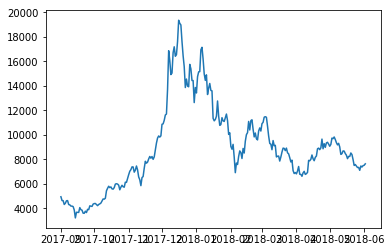

In [6]:
plt.plot(ts)

In [7]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


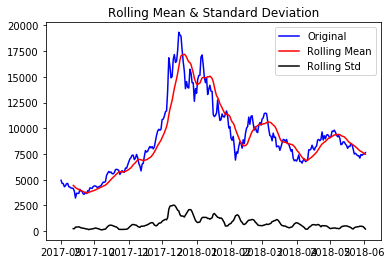

Results of Dickey-Fuller Test:
Test Statistic                  -2.178637
p-value                          0.214090
#Lags Used                      10.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


In [8]:
test_stationarity(ts)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


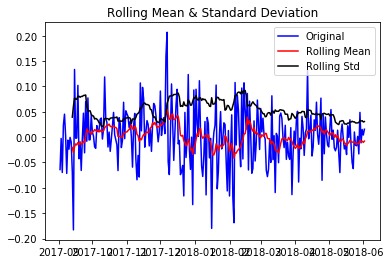

Results of Dickey-Fuller Test:
Test Statistic                -1.617081e+01
p-value                        4.366802e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.730000e+02
Critical Value (1%)           -3.454533e+00
Critical Value (5%)           -2.872186e+00
Critical Value (10%)          -2.572443e+00
dtype: float64


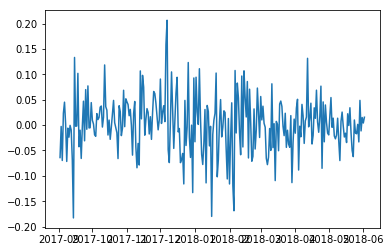

In [9]:
ts_log = np.log(ts / ts.shift()).dropna()
test_stationarity(ts_log)
plt.plot(ts_log)

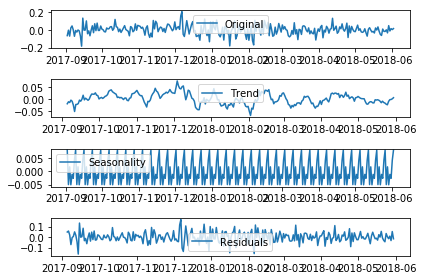

In [10]:
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


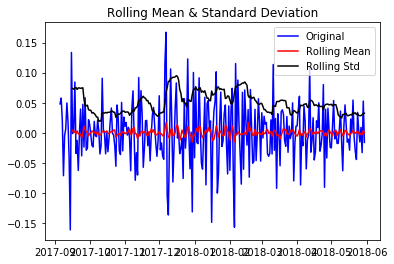

Results of Dickey-Fuller Test:
Test Statistic                -7.213799e+00
p-value                        2.199767e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


In [11]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [12]:
lag_acf = acf(ts_log_decompose, nlags=20)
lag_pacf = pacf(ts_log_decompose, nlags=20, method='ols')

In [ ]:
"""
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
"""

In [ ]:
"""
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_decompose)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
"""

/usr/local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


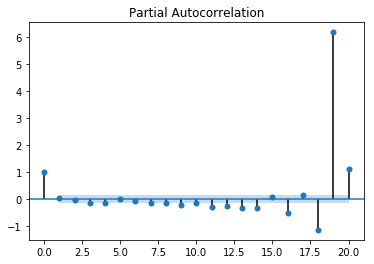

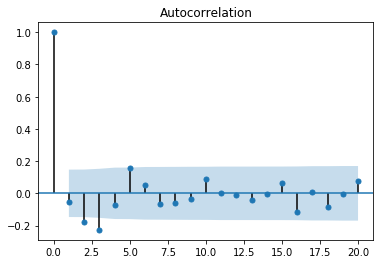

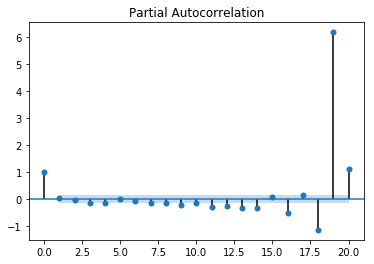

In [13]:
smt.graphics.plot_acf(lag_acf, lags=20, alpha=0.5)
smt.graphics.plot_pacf(lag_pacf, lags=20, alpha=0.5)

In [14]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl
# Notice I've selected a specific time period to run this analysis
res_tup = _get_best_model(ts_log_decompose)

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packa

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packa

aic: -1008.73243 | order: (4, 0, 2)


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packa

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 0.4958')

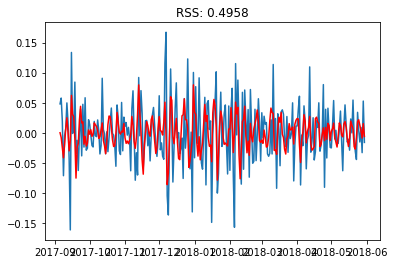

In [15]:
model = ARIMA(ts_log_decompose, order=(4, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_decompose)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_decompose)**2))


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Text(0.5,1,'RSS: 0.4283')

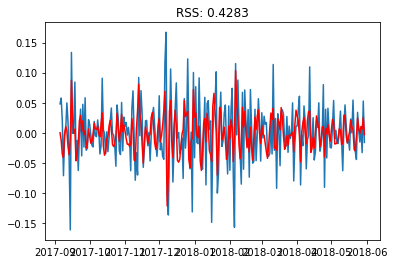

In [16]:
model = ARIMA(ts_log_decompose, order=(0, 0, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_decompose)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - ts_log_decompose)**2))

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5,1,'RSS: 0.3767')

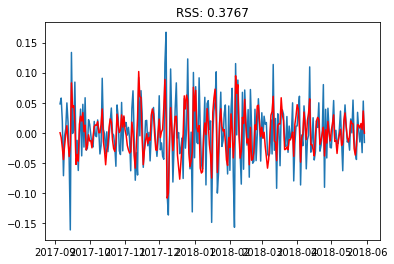

In [17]:
model = ARIMA(ts_log_decompose, order=(4, 0, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_decompose)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - ts_log_decompose)**2))

In [18]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

date
2017-09-05    0.000003
2017-09-06   -0.007847
2017-09-07   -0.024732
2017-09-08   -0.044586
2017-09-09   -0.021115
dtype: float64


In [19]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

date
2017-09-05    0.000003
2017-09-06   -0.007844
2017-09-07   -0.032576
2017-09-08   -0.077162
2017-09-09   -0.098277
dtype: float64


In [20]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


date
2017-09-02   -0.063963
2017-09-03   -0.063963
2017-09-04   -0.063963
2017-09-05   -0.063960
2017-09-06   -0.071807
dtype: float64

Text(0.5,1,'RMSE: 2264.9247')

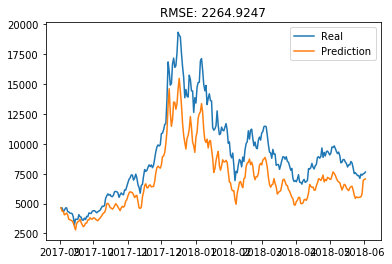

In [21]:
predictions_ARIMA = (np.exp(predictions_ARIMA_log)) * ts.shift().dropna()
plt.plot(ts['2017-09-02':], label='Real')
plt.legend(loc='best')
plt.plot(predictions_ARIMA, label='Prediction')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA - ts['2017-09-02':])**2) / len(ts)))

In [22]:
garch = arch_model(ts_log_decompose, p=4, q=2)
res = garch.fit(update_freq=10)
print(res.summary())

Iteration:     10,   Func. Count:    115,   Neg. LLF: -432.5986834978644
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -432.8716394168049
            Iterations: 16
            Function evaluations: 175
            Gradient evaluations: 16
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  price   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                432.872
Distribution:                  Normal   AIC:                          -849.743
Method:            Maximum Likelihood   BIC:                          -821.015
                                        No. Observations:                  268
Date:                Mon, Jun 04 2018   Df Residuals:                      260
Time:                        00:18:46   Df Model:                            8
    

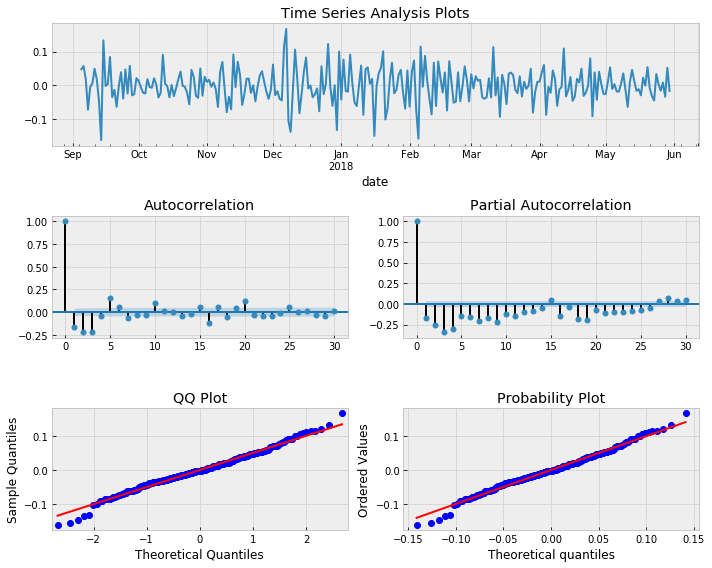

In [23]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 
tsplot(res.resid, lags=30)

In [ ]:
#Reference:
"""
https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

"""